# 《台灣電力現況與能源結構完整分析報告》


## 1. 前言
本報告依據 `target.txt` 所提出的 PROMPT，綜整台灣電力供需、能源結構、燃料耗用、用電行為、發電成本、再生能源與核能減碳等面向，並輔以圖表與文字解讀，以協助研判台灣能源轉型與供電安全的現況。



## 2. 資料與方法
- 資料來源：`data_clean/` 目錄中的整理後 CSV 檔案，欄位定義參照 `codebook_clean/`。
- 套件：pandas 用於資料處理，matplotlib 進行視覺化，並設定 `plt.rcParams['font.family'] = ['Heiti TC', 'Taipei Sans TC Beta', 'Microsoft JhengHei', 'sans-serif']` 與 `plt.rcParams['axes.unicode_minus'] = False`。
- 繪圖原始碼可在 `scripts/visualize_themes.py` 與本 Notebook 中直接檢視與重現。


In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ===============================
#  專為 macOS 的 Matplotlib 中文字體模板
# ===============================

# 你可能已經安裝的中文字體（由上到下優先）
preferred_fonts = [
    "Heiti TC",          # macOS 內建
    "PingFang TC",       # macOS 內建
    "Hiragino Sans GB",  # macOS 內建（簡中）
    "Songti SC",         # macOS 內建（簡中）
    "Arial Unicode MS",  # 跨平台
    "Noto Sans CJK TC"   # 若有裝 Google 字體
]

# 找出系統能用的字體
available = {f.name for f in fm.fontManager.ttflist}

chosen = None
for font in preferred_fonts:
    if font in available:
        chosen = font
        break

if chosen is None:
    raise Exception("⚠ 找不到可用中文字體，請安裝 Noto Sans CJK TC。")

plt.rcParams['font.family'] = chosen
plt.rcParams['axes.unicode_minus'] = False  # 確保負號正常

print(f"✅ Matplotlib 已成功使用中文字體：{chosen}")


✅ Matplotlib 已成功使用中文字體：Heiti TC


In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

preferred = [
    "/System/Library/Fonts/PingFang.ttc",
    "/System/Library/Fonts/Songti.ttc",
    "/System/Library/Fonts/STHeiti Medium.ttc",
]

font_path = None
for p in preferred:
    try:
        fp = fm.FontProperties(fname=p)
        font_path = p
        break
    except:
        continue

if font_path is None:
    raise Exception("找不到可用的中文字型")

prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False
print("使用字型：", prop.get_name())


使用字型： PingFang HK


In [3]:

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown


DATA_DIR = Path('data_clean')
context = {}


## 3. 供需分析

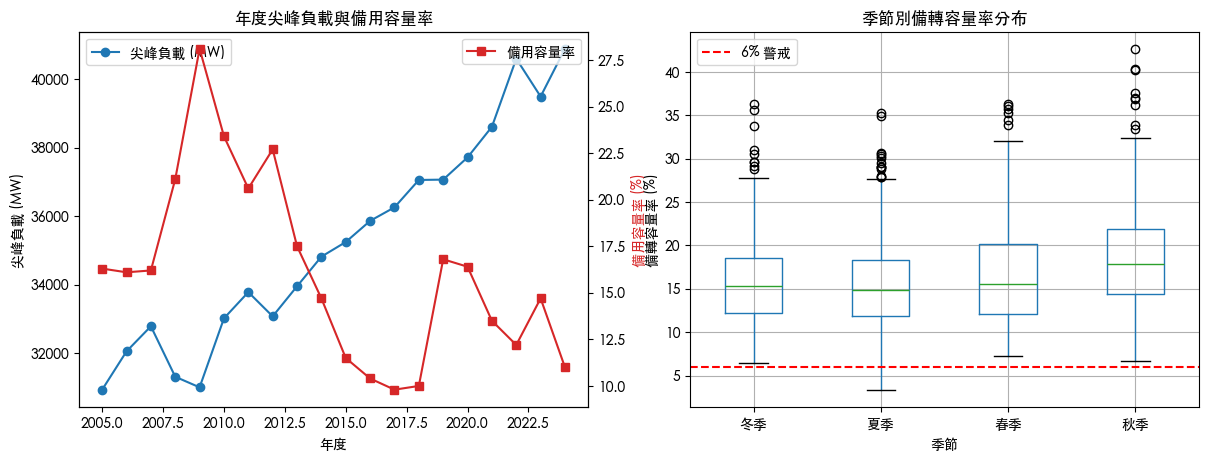

In [4]:

peak_annual = pd.read_csv(DATA_DIR / 'annual_peak_load_and_reserve.csv').dropna().sort_values('year')
recent_peak = peak_annual[peak_annual['year'] >= 2005]
reserve_day = pd.read_csv(DATA_DIR / 'three_year_daily_reserve_margin.csv', parse_dates=['date']).dropna()
reserve_day['season'] = reserve_day['date'].dt.month % 12 // 3
season_map = {0: '冬季', 1: '春季', 2: '夏季', 3: '秋季'}
reserve_day['season_label'] = reserve_day['season'].map(season_map)
low_days = reserve_day[reserve_day['reserve_margin_pct'] < 6]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(recent_peak['year'], recent_peak['peak_load_mw'], marker='o', label='尖峰負載 (MW)')
ax.set_ylabel('尖峰負載 (MW)')
ax.set_xlabel('年度')
ax2 = ax.twinx()
ax2.plot(recent_peak['year'], recent_peak['reserve_margin_pct'], color='tab:red', marker='s', label='備用容量率')
ax2.set_ylabel('備用容量率 (%)', color='tab:red')
ax.set_title('年度尖峰負載與備用容量率')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

reserve_day.boxplot(column='reserve_margin_pct', by='season_label', ax=axes[1])
axes[1].axhline(6, color='red', linestyle='--', label='6% 警戒')
axes[1].set_title('季節別備轉容量率分布')
axes[1].set_xlabel('季節')
axes[1].set_ylabel('備轉容量率 (%)')
axes[1].legend()
fig.suptitle('')
plt.show()

context['supply'] = {
    'latest_year': int(recent_peak['year'].iloc[-1]),
    'latest_load': float(recent_peak['peak_load_mw'].iloc[-1]),
    'latest_reserve': float(recent_peak['reserve_margin_pct'].iloc[-1]),
    'min_reserve_recent': float(recent_peak['reserve_margin_pct'].min()),
    'low_days': len(low_days),
    'last_low_date': low_days['date'].max().date() if len(low_days) else None
}


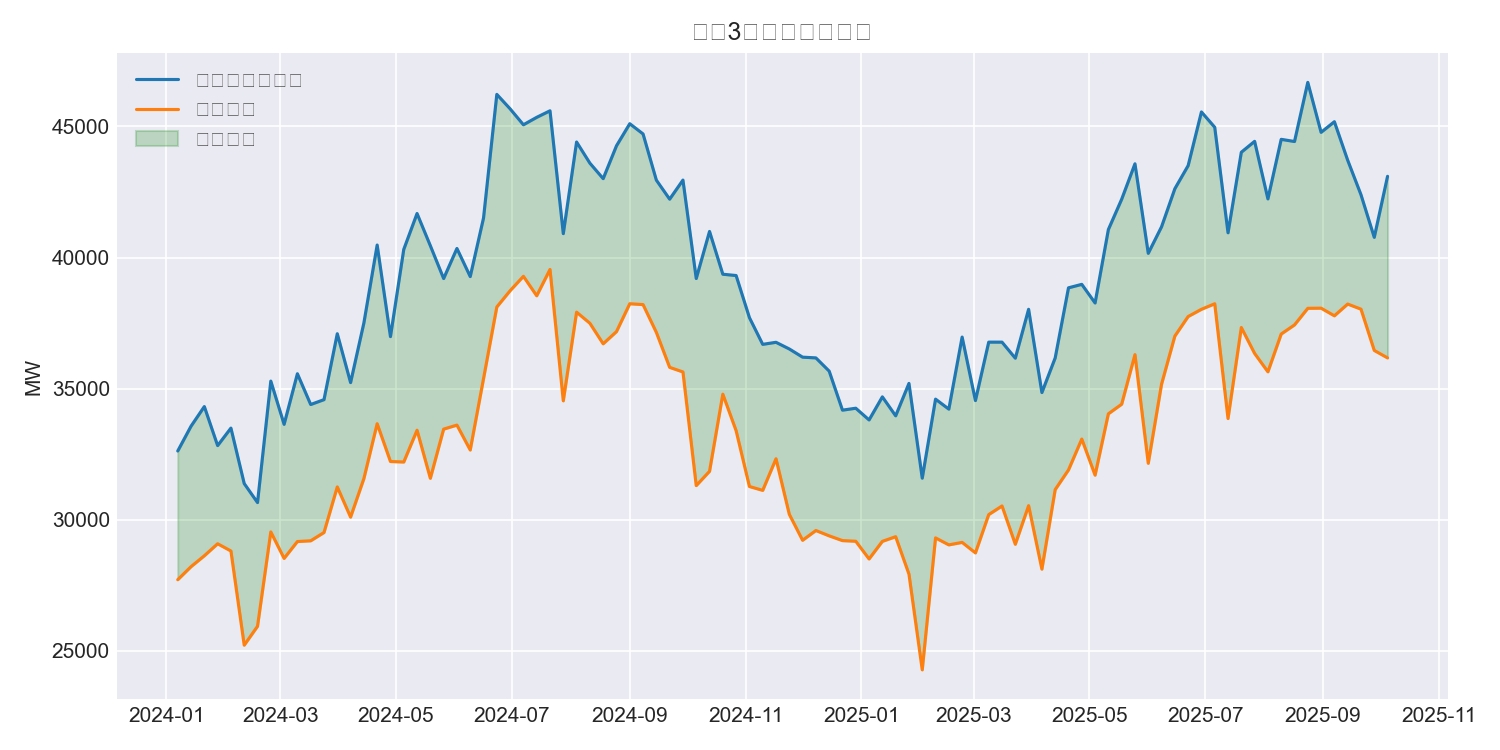

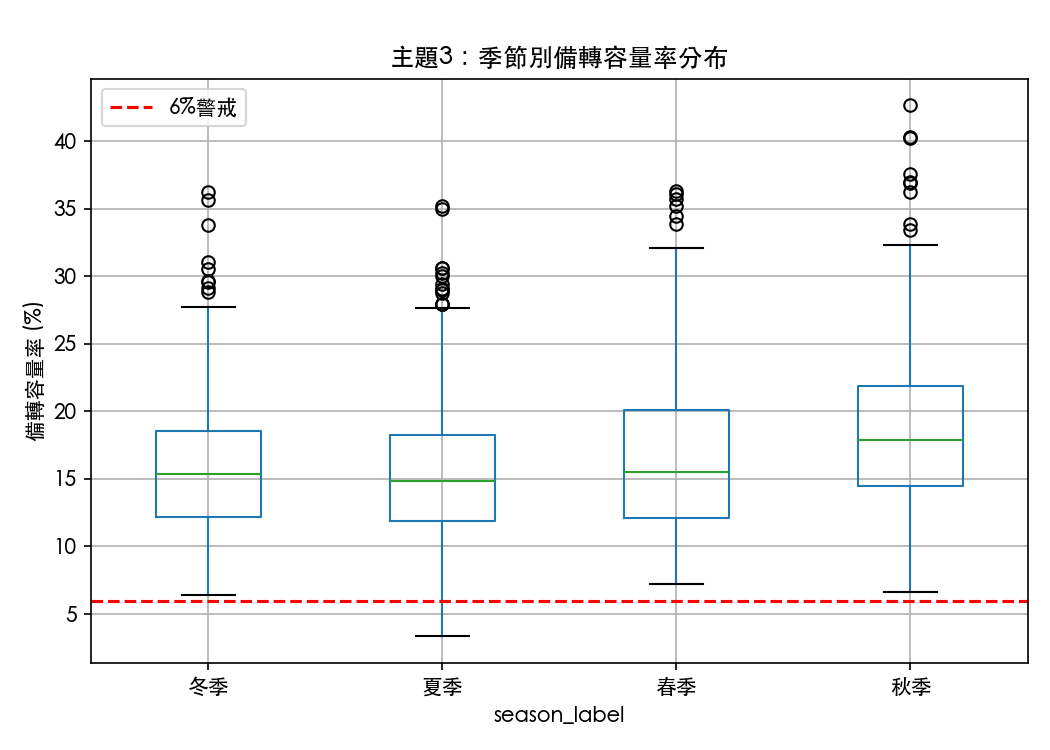

In [14]:

latest_year = context['supply']['latest_year']
latest_load = context['supply']['latest_load']
latest_reserve = context['supply']['latest_reserve']
min_reserve_recent = context['supply']['min_reserve_recent']
low_days = context['supply']['low_days']
last_low_date = context['supply']['last_low_date']

text = f"""
**圖表解讀**<br>
1. {latest_year} 年尖峰負載達 {latest_load:,.0f} MW，創近年新高。<br>
2. 同年度備用容量率僅 {latest_reserve:.1f}%，顯示備轉空間持續收斂。<br>
3. 2005 年以來最低備用容量率約 {min_reserve_recent:.1f}%，長期趨勢未改善。<br>
4. 過去三年共有 {low_days} 天跌破 6% 警戒，最近一次出現在 {last_low_date}。<br>
5. 夏季箱型圖呈現分布偏低且波動大，冬季則遠高於 20%。<br>
6. 若無新增調度容量或需求面管理，尖峰負載再成長將把備轉率推向危險區。<br>
"""
Markdown(text)



**圖表解讀**<br>
1. 2024 年尖峰負載達 40,882 MW，創近年新高。<br>
2. 同年度備用容量率僅 11.0%，顯示備轉空間持續收斂。<br>
3. 2005 年以來最低備用容量率約 9.8%，長期趨勢未改善。<br>
4. 過去三年共有 2 天跌破 6% 警戒，最近一次出現在 2022-08-24。<br>
5. 夏季箱型圖呈現分布偏低且波動大，冬季則遠高於 20%。<br>
6. 若無新增調度容量或需求面管理，尖峰負載再成長將把備轉率推向危險區。<br>


## 4. 發電結構分析

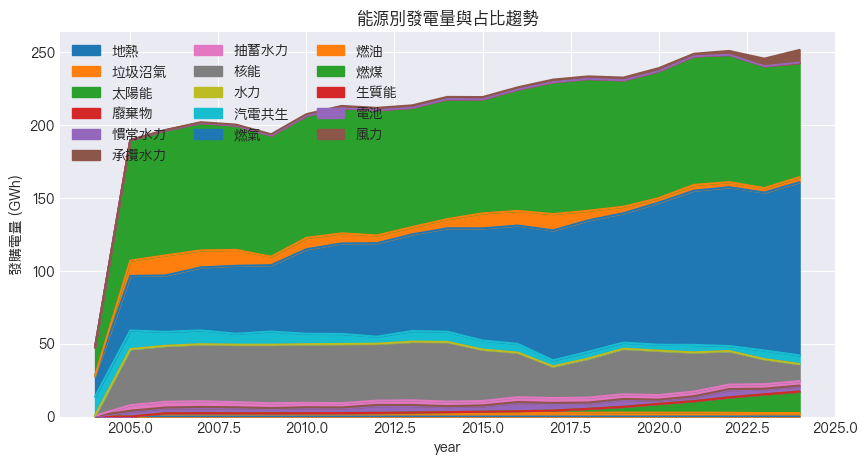

In [15]:

gen = pd.read_csv(DATA_DIR / 'generation_by_energy_type.csv')
gen_agg = gen.groupby(['year', 'energy_type'])['generation_kwh'].sum().reset_index()
pivot = gen_agg.pivot(index='year', columns='energy_type', values='generation_kwh').fillna(0) / 1e9
pivot = pivot.sort_index()
fig, ax = plt.subplots(figsize=(10, 5))
pivot.plot.area(ax=ax)
ax.set_ylabel('發購電量 (GWh)')
ax.set_title('能源別發電量與占比趨勢')
ax.legend(loc='upper left', ncol=3)
plt.show()

latest_year = int(gen_agg['year'].max())
latest = gen_agg[gen_agg['year'] == latest_year]
total_latest = latest['generation_kwh'].sum()
share = latest.assign(share=lambda d: d['generation_kwh'] / total_latest * 100)
major = share[share['energy_type'].isin(['燃氣', '燃煤', '核能', '太陽能', '風力'])]
context['energy_mix'] = {
    'latest_year': latest_year,
    'shares': dict(zip(major['energy_type'], major['share']))
}


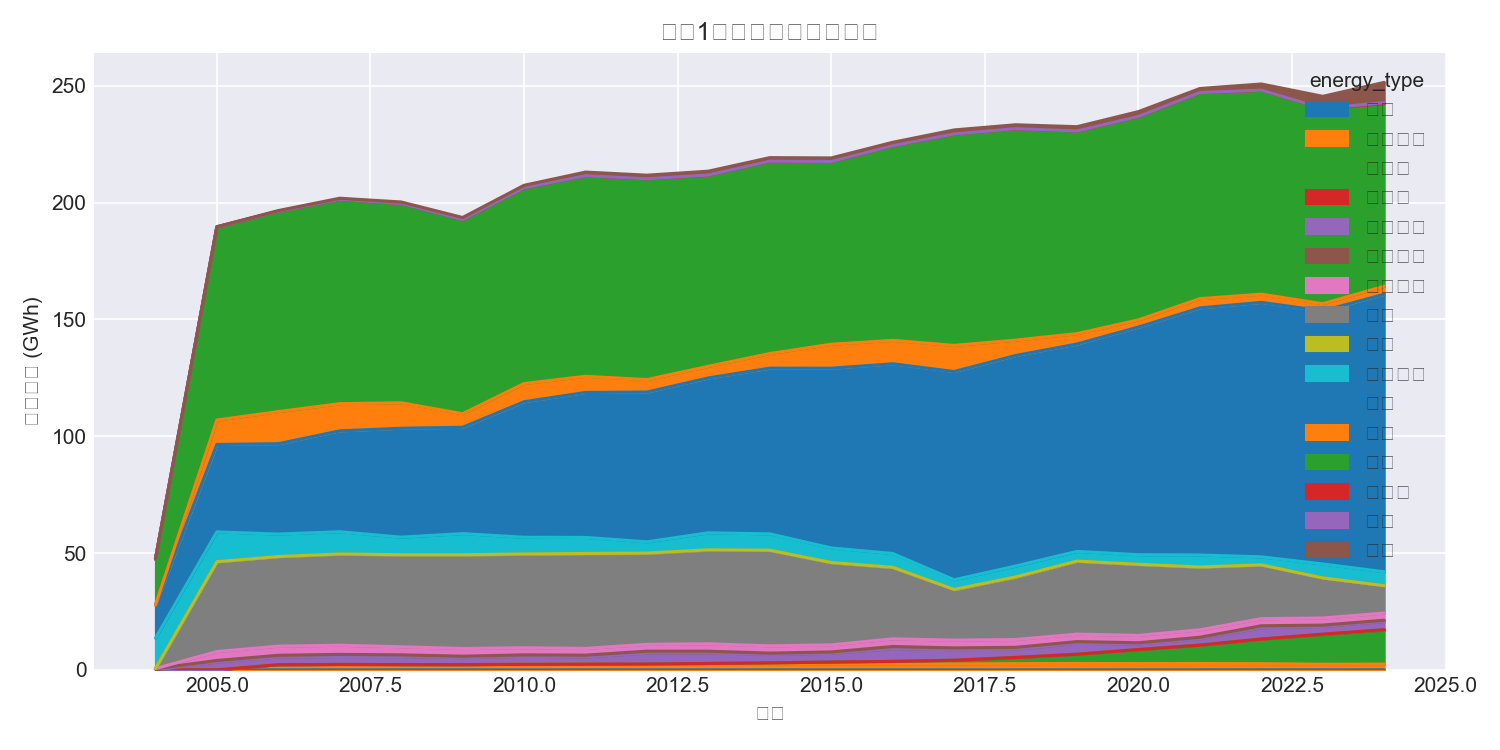

In [16]:

latest_year = context['energy_mix']['latest_year']
shares = context['energy_mix']['shares']
text = f"""
**圖表解讀**<br>
1. {latest_year} 年燃氣占比約 {shares.get('燃氣', 0):.1f}%。<br>
2. 燃煤占比約 {shares.get('燃煤', 0):.1f}%，雖下降仍為關鍵基載。<br>
3. 核能占比僅 {shares.get('核能', 0):.1f}%，除役效應明顯。<br>
4. 太陽能與風力合計僅約 {shares.get('太陽能', 0)+shares.get('風力', 0):.1f}%。<br>
5. 堆疊圖顯示燃氣自 2014 年後快速擴張。<br>
6. 再生能源近五年才大量增加，仍需搭配儲能。<br>
"""
Markdown(text)



**圖表解讀**<br>
1. 2024 年燃氣占比約 47.2%。<br>
2. 燃煤占比約 31.1%，雖下降仍為關鍵基載。<br>
3. 核能占比僅 4.7%，除役效應明顯。<br>
4. 太陽能與風力合計僅約 9.3%。<br>
5. 堆疊圖顯示燃氣自 2014 年後快速擴張。<br>
6. 再生能源近五年才大量增加，仍需搭配儲能。<br>


## 5. 裝置容量分析

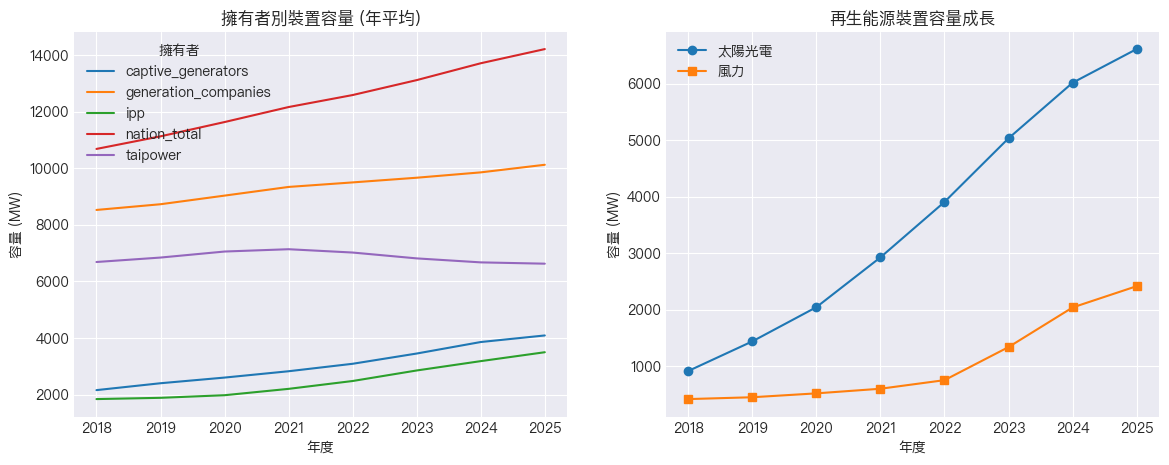

In [17]:

cap = pd.read_csv(DATA_DIR / 'generation_capacity_long.csv', parse_dates=['period'])
cap['year'] = cap['period'].dt.year
recent_cap = cap[cap['year'] >= 2018]
owner = recent_cap.groupby(['year', 'owner_group'])['capacity_mw'].mean().reset_index()
pivot_owner = owner.pivot(index='year', columns='owner_group', values='capacity_mw').fillna(0)
solar = recent_cap[recent_cap['technology'].str.contains('太陽光電', na=False)].groupby('year')['capacity_mw'].mean()
wind = recent_cap[recent_cap['technology'].str.contains('風力', na=False)].groupby('year')['capacity_mw'].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
pivot_owner.plot(ax=axes[0])
axes[0].set_title('擁有者別裝置容量 (年平均)')
axes[0].set_ylabel('容量 (MW)')
axes[0].legend(title='擁有者')
axes[0].set_xlabel('年度')

axes[1].plot(solar.index, solar.values, marker='o', label='太陽光電')
axes[1].plot(wind.index, wind.values, marker='s', label='風力')
axes[1].set_title('再生能源裝置容量成長')
axes[1].set_ylabel('容量 (MW)')
axes[1].set_xlabel('年度')
axes[1].legend()
plt.show()

context['capacity'] = {
    'latest_solar': float(solar.iloc[-1]),
    'latest_wind': float(wind.iloc[-1]),
    'taipower': float(pivot_owner['taipower'].iloc[-1]),
    'ipp': float(pivot_owner['ipp'].iloc[-1]) if 'ipp' in pivot_owner else np.nan
}


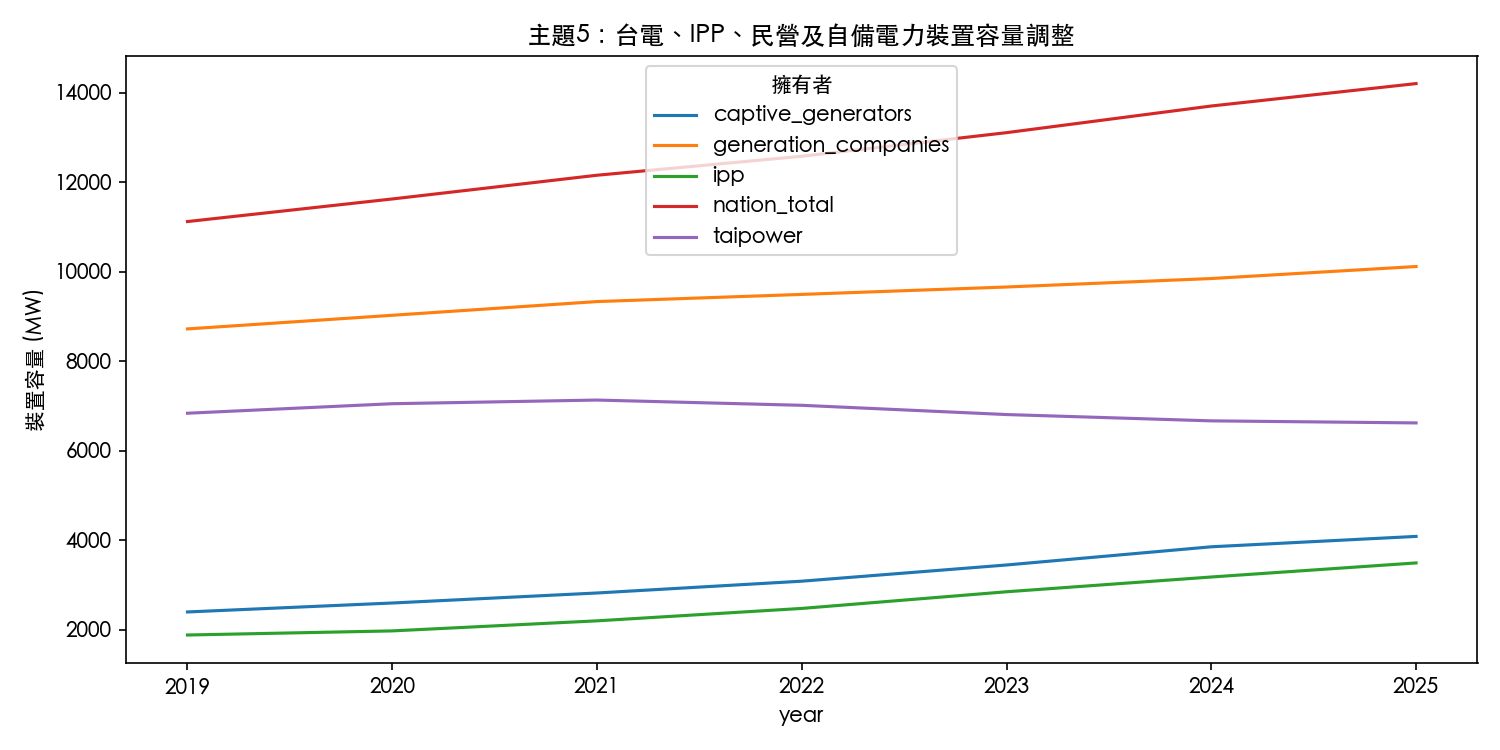

In [ ]:

data = context['capacity']
text = f"""
**圖表解讀**<br>
1. 台電自有容量約 {data['taipower']:,.0f} MW，呈略降趨勢。<br>
2. IPP 容量逐年上升，民間成為新增電源主力。<br>
3. 自備電力也增加，顯示工業用戶自建備援。<br>
4. 太陽光電容量已達 {data['latest_solar']:.0f} MW。<br>
5. 風力容量升至 {data['latest_wind']:.0f} MW，海上風場貢獻顯著。<br>
6. 再生容量尚未完全取代燃煤/核能提供的穩定基載。<br>
"""
Markdown(text)


## 6. 燃料耗用分析

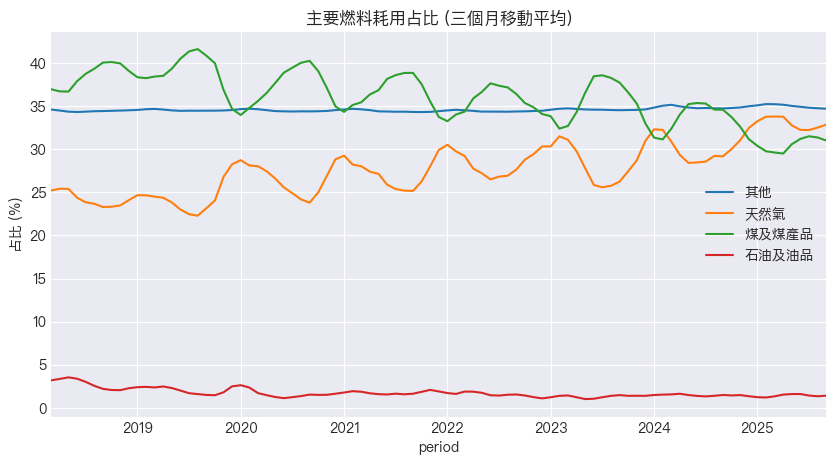

In [18]:

fuel = pd.read_csv(DATA_DIR / 'generation_fuel_consumption_long.csv', parse_dates=['period'])
fuel = fuel[fuel['period'] >= pd.Timestamp('2018-01-01')]

def classify(name):
    if isinstance(name, float):
        return '其他'
    if '煤' in name:
        return '煤及煤產品'
    if '氣' in name or '天然氣' in name:
        return '天然氣'
    if '油' in name or '石油' in name:
        return '石油及油品'
    return '其他'

fuel['category'] = fuel['fuel'].apply(classify)
pivot_fuel = fuel.pivot_table(index='period', columns='category', values='consumption_units', aggfunc='sum').fillna(0)
shares = pivot_fuel.divide(pivot_fuel.sum(axis=1), axis=0) * 100
shares = shares.rolling(3).mean().dropna()
fig, ax = plt.subplots(figsize=(10, 5))
shares.plot(ax=ax)
ax.set_title('主要燃料耗用占比 (三個月移動平均)')
ax.set_ylabel('占比 (%)')
ax.legend()
plt.show()

last_row = shares.iloc[-1]
context['fuel'] = {cat: float(val) for cat, val in last_row.items()}


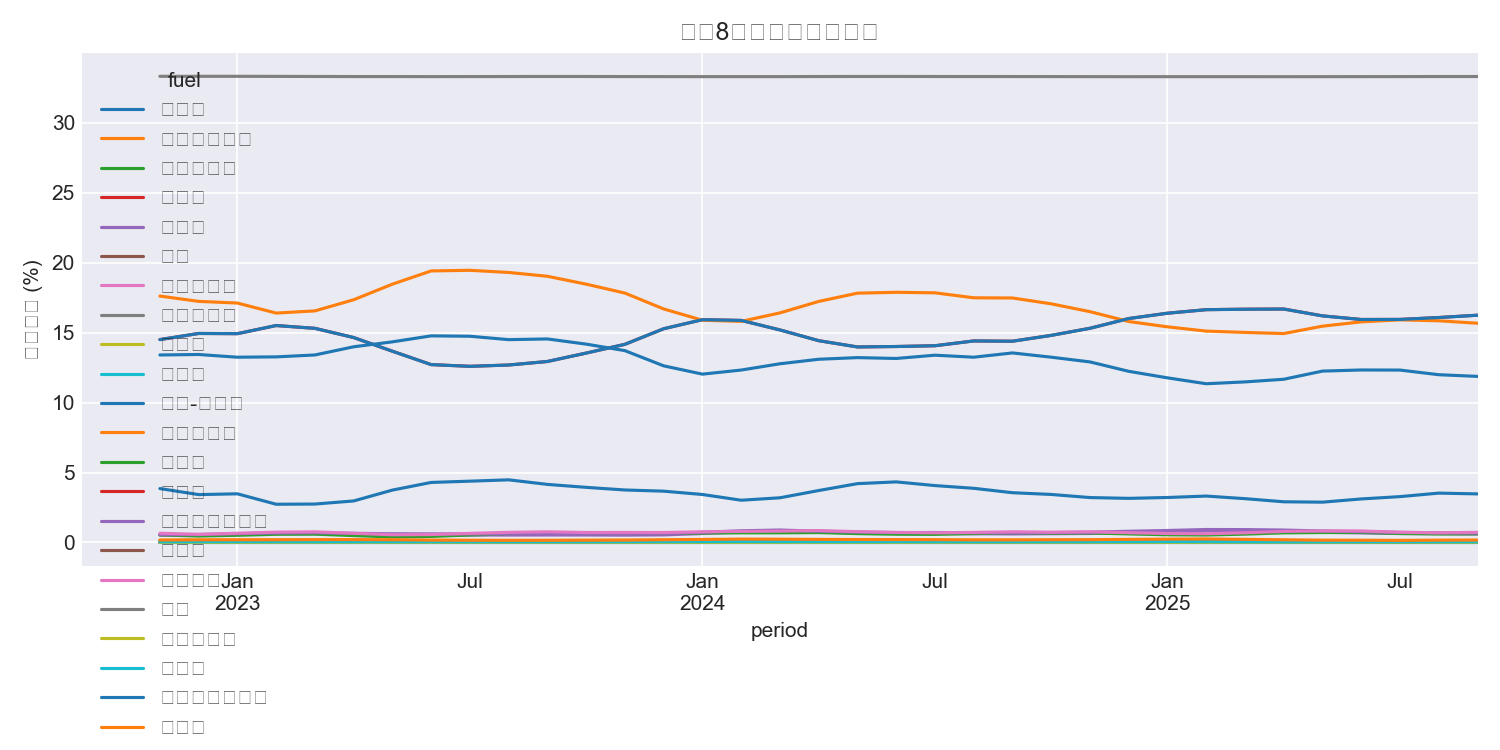

In [ ]:

shares = context['fuel']
text = f"""
**圖表解讀**<br>
1. 天然氣耗用占比已超過 {shares.get('天然氣', 0):.1f}%。<br>
2. 煤及煤產品降至 {shares.get('煤及煤產品', 0):.1f}% 左右。<br>
3. 石油及油品維持在 {shares.get('石油及油品', 0):.1f}% 以內。<br>
4. 其他燃料占比不到 {shares.get('其他', 0):.1f}%。<br>
5. 燃料結構轉向天然氣代表進口依賴升高。<br>
6. 氣源若受限，系統缺口難以由燃煤即時填補。<br>
"""
Markdown(text)


## 7. 用電結構分析

/var/folders/7t/lv1vfzs91txg1j8rzt3p4y4r0000gn/T/ipykernel_84613/976854873.py:14: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = axes[1].imshow(recent_heat, aspect='auto', cmap='YlOrRd')
/var/folders/7t/lv1vfzs91txg1j8rzt3p4y4r0000gn/T/ipykernel_84613/976854873.py:14: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = axes[1].imshow(recent_heat, aspect='auto', cmap='YlOrRd')


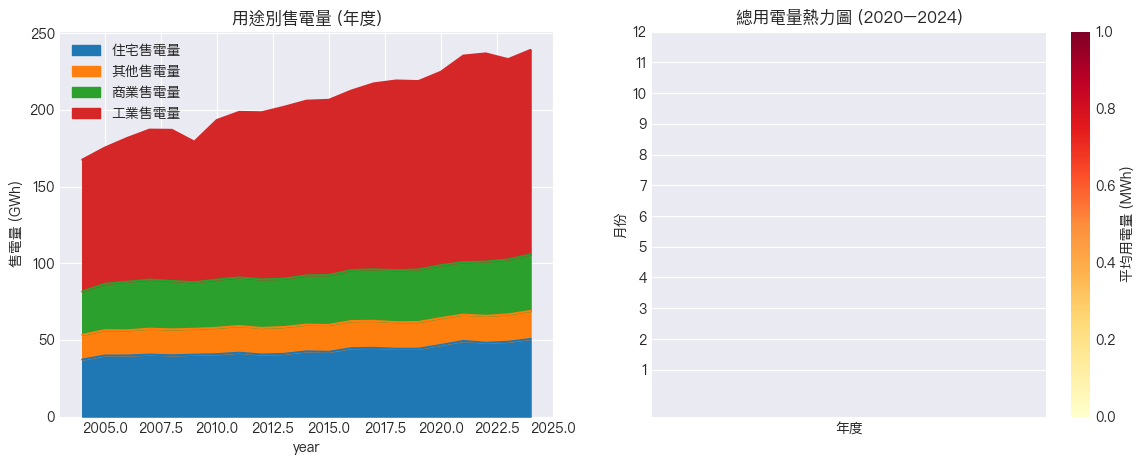

In [19]:

sales = pd.read_csv(DATA_DIR / 'electricity_sales_by_usage.csv')
table = sales.pivot(index='year', columns='usage_category', values='sales_kwh').fillna(0) / 1e9
cons = pd.read_csv(DATA_DIR / 'electricity_consumption_by_sector.csv', parse_dates=['period'])
cons['year'] = cons['period'].dt.year
cons['month'] = cons['period'].dt.month
recent_heat = cons[cons['year'] >= 2020].pivot_table(index='month', columns='year', values='total_mwh', aggfunc='mean')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
table.plot.area(ax=axes[0])
axes[0].set_title('用途別售電量 (年度)')
axes[0].set_ylabel('售電量 (GWh)')
axes[0].legend(loc='upper left')

im = axes[1].imshow(recent_heat, aspect='auto', cmap='YlOrRd')
axes[1].set_title('總用電量熱力圖 (2020–2024)')
axes[1].set_xlabel('年度')
axes[1].set_ylabel('月份')
axes[1].set_xticks(range(len(recent_heat.columns)), recent_heat.columns)
axes[1].set_yticks(range(1, 13))
fig.colorbar(im, ax=axes[1], label='平均用電量 (MWh)')
plt.show()

latest_sales = sales[sales['year'] == sales['year'].max()].set_index('usage_category')['sales_kwh']
total_sales = latest_sales.sum()
context['demand'] = {
    'industrial_share': latest_sales['工業售電量'] / total_sales * 100,
    'residential_share': latest_sales['住宅售電量'] / total_sales * 100,
    'commercial_share': latest_sales['商業售電量'] / total_sales * 100
}


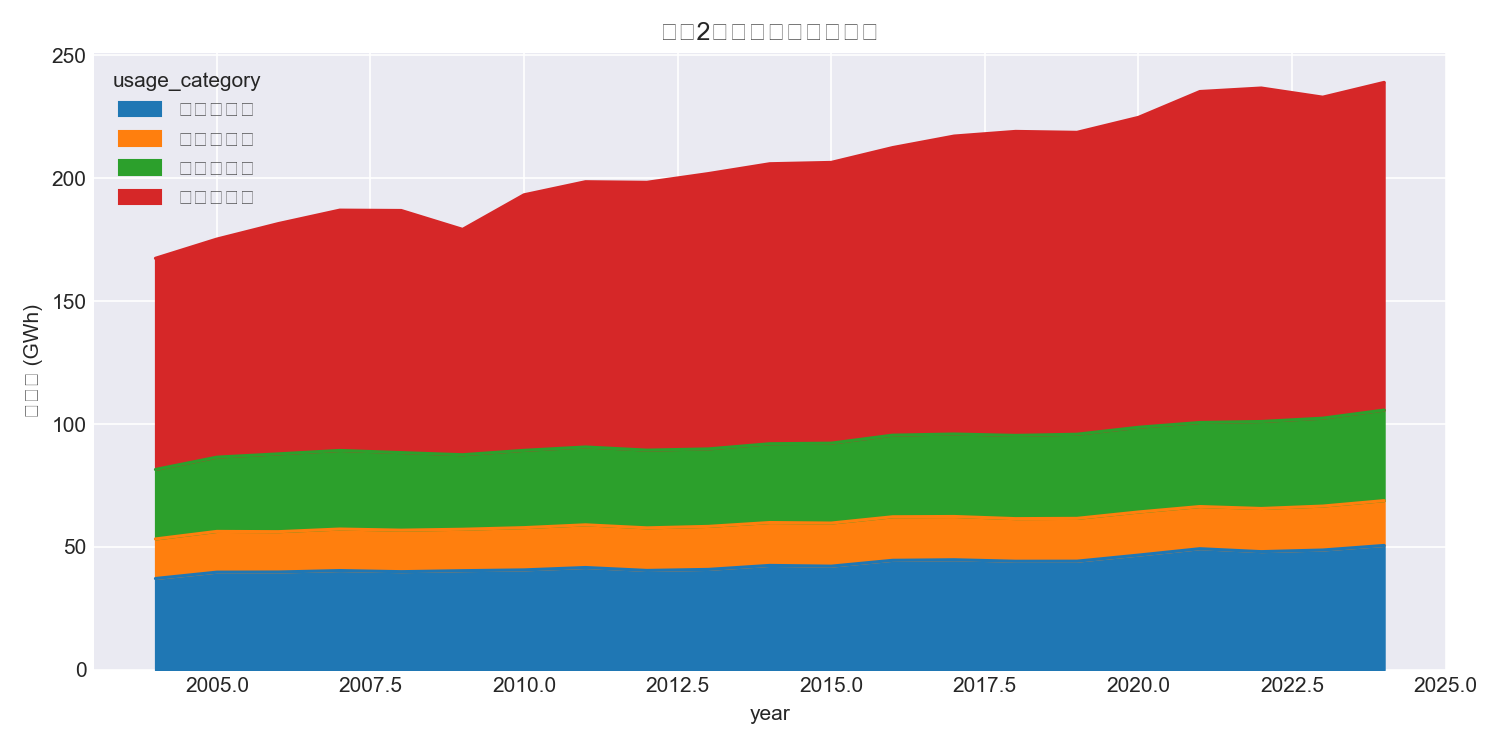

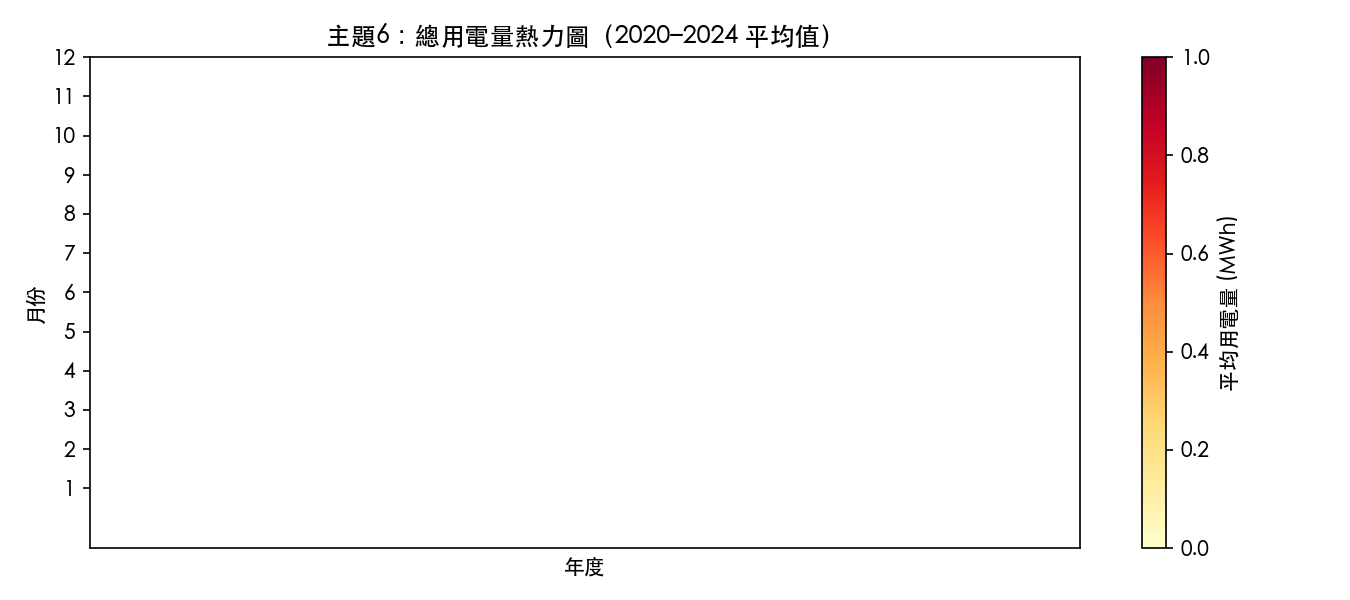

In [20]:

data = context['demand']
text = f"""
**圖表解讀**<br>
1. 工業用電占比約 {data['industrial_share']:.1f}%，為需求主體。<br>
2. 住宅與商業占比分別約 {data['residential_share']:.1f}% 與 {data['commercial_share']:.1f}%。<br>
3. 工業曲面在 2009 後明顯抬升，與電子產業擴產同步。<br>
4. 熱力圖顯示 7–9 月顏色最深，夏季負載最高。<br>
5. 冬季顏色淡，顯示尖峰差距大。<br>
6. 工業依賴度高意味景氣波動直接牽動負載。<br>
"""
Markdown(text)



**圖表解讀**<br>
1. 工業用電占比約 55.8%，為需求主體。<br>
2. 住宅與商業占比分別約 21.2% 與 15.4%。<br>
3. 工業曲面在 2009 後明顯抬升，與電子產業擴產同步。<br>
4. 熱力圖顯示 7–9 月顏色最深，夏季負載最高。<br>
5. 冬季顏色淡，顯示尖峰差距大。<br>
6. 工業依賴度高意味景氣波動直接牽動負載。<br>


## 8. 發電成本分析

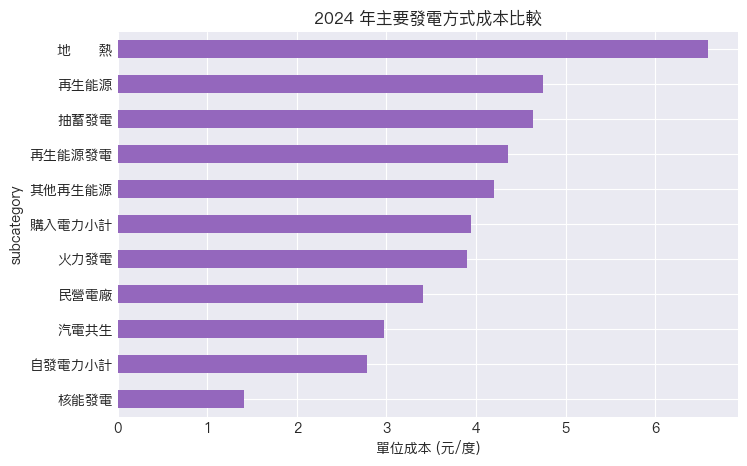

In [21]:

cost = pd.read_csv(DATA_DIR / 'generation_costs_by_technology.csv')
latest_year = cost['calendar_year'].max()
latest = cost[(cost['calendar_year'] == latest_year) & cost['subcategory'].notna()]
summary = latest.groupby('subcategory')['cost_ntd_per_kwh'].mean().sort_values()
fig, ax = plt.subplots(figsize=(8, 5))
summary.plot(kind='barh', ax=ax, color='tab:purple')
ax.set_xlabel('單位成本 (元/度)')
ax.set_title(f'{latest_year} 年主要發電方式成本比較')
plt.show()

context['cost'] = summary


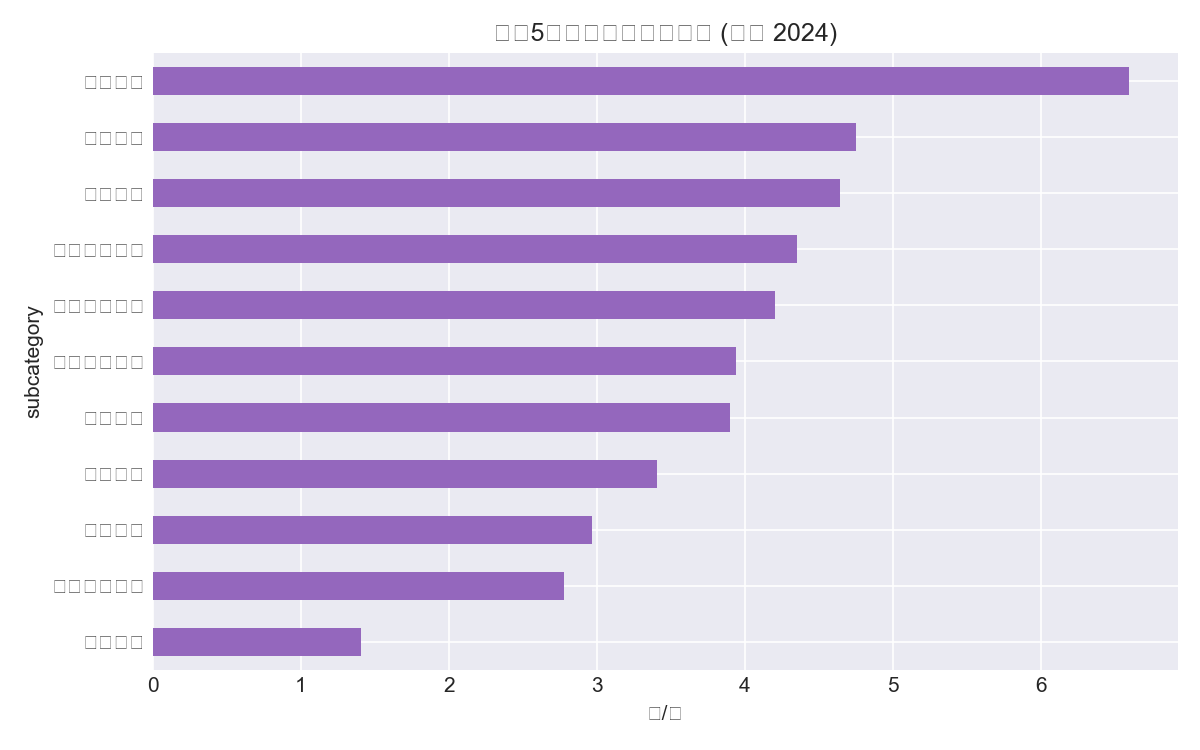

In [ ]:

sum_cost = context['cost']
text = f"""
**圖表解讀**<br>
1. 核能成本約 {sum_cost.get('核能發電', float('nan')):.2f} 元/度，最低。<br>
2. 火力成本約 {sum_cost.get('火力發電', float('nan')):.2f} 元/度。<br>
3. 再生能源介於 4–5 元/度，逐年下降。<br>
4. 購入電力成本高於自發電，顯示市場化需配套。<br>
5. 抽蓄與其他再生能源成本較高，顯示儲能仍在投資期。<br>
6. 核能退場將推升平均供電成本。<br>
"""
Markdown(text)


## 9. 再生能源分析

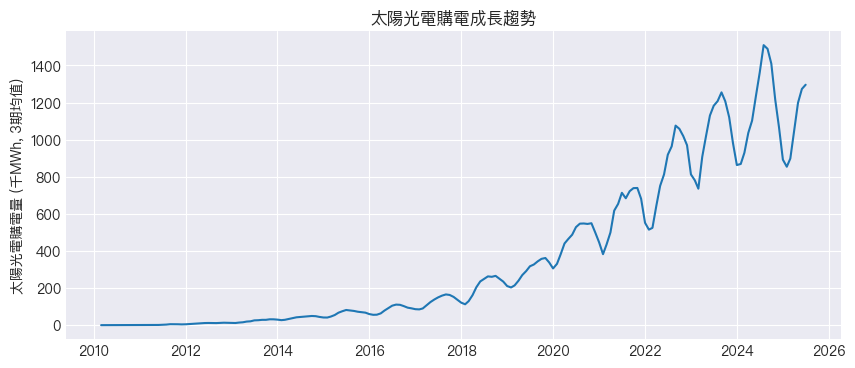

In [22]:

solar = pd.read_csv(DATA_DIR / 'solar_feed_in_records.csv')
solar = solar[~solar['is_annual_total']].copy()
solar['period'] = pd.to_datetime(solar['period'])
solar_monthly = solar.groupby('period')['energy_mwh'].sum().rolling(3).mean()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(solar_monthly.index, solar_monthly.values / 1000)
ax.set_ylabel('太陽光電購電量 (千MWh, 3期均值)')
ax.set_title('太陽光電購電成長趨勢')
plt.show()

annual = solar.groupby(solar['period'].dt.year)['energy_mwh'].sum()
context['renew'] = {
    'latest_year': int(annual.index.max()),
    'latest_energy': float(annual.iloc[-1] / 1000),
    'prev_energy': float(annual.iloc[-2] / 1000)
}


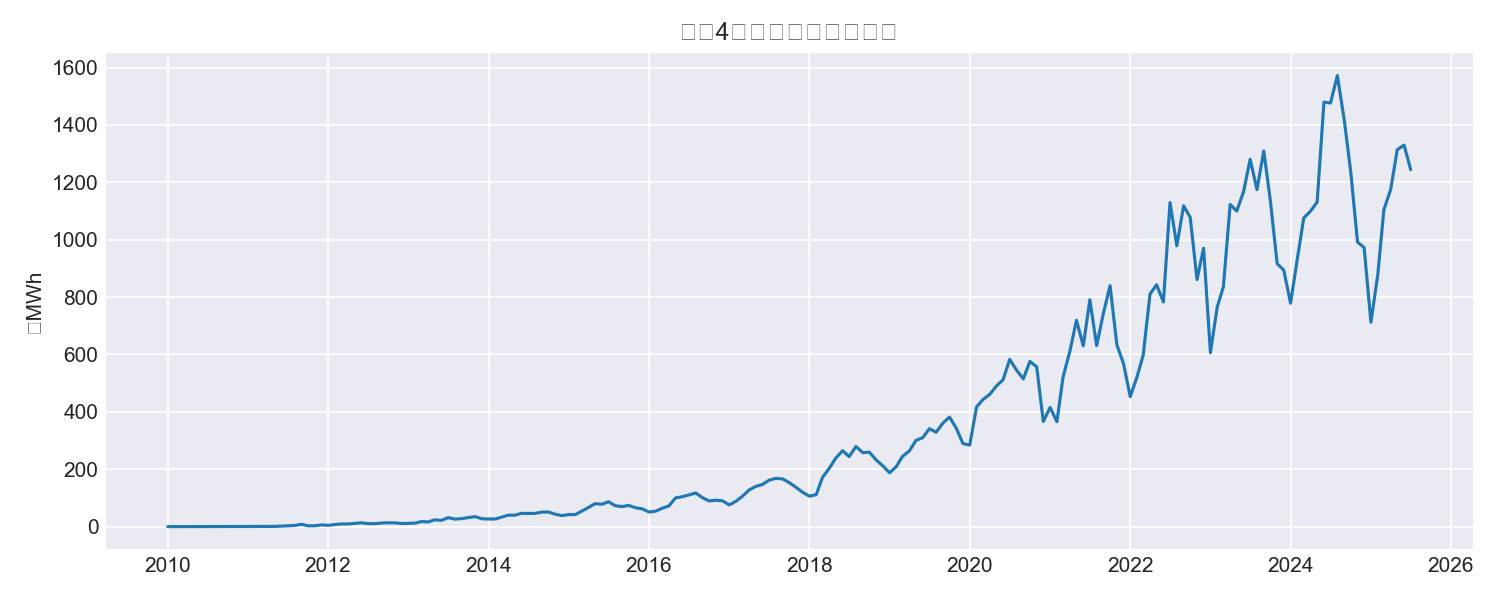

In [23]:

data = context['renew']
text = f"""
**圖表解讀**<br>
1. {data['latest_year']-1} 年太陽光電購電量約 {data['prev_energy']:,.0f} 千MWh。<br>
2. {data['latest_year']} 年仍維持 {data['latest_energy']:,.0f} 千MWh。<br>
3. 3 期移動平均呈現長期上升趨勢。<br>
4. 近年短暫回落反映天候與施工期影響。<br>
5. 太陽光電主要支援白天尖峰，夜間需儲能或燃氣補位。<br>
6. 達成再生能源目標需同步推動風電與儲能。<br>
"""
Markdown(text)



**圖表解讀**<br>
1. 2024 年太陽光電購電量約 14,167 千MWh。<br>
2. 2025 年仍維持 7,757 千MWh。<br>
3. 3 期移動平均呈現長期上升趨勢。<br>
4. 近年短暫回落反映天候與施工期影響。<br>
5. 太陽光電主要支援白天尖峰，夜間需儲能或燃氣補位。<br>
6. 達成再生能源目標需同步推動風電與儲能。<br>


## 10. 核能與減碳

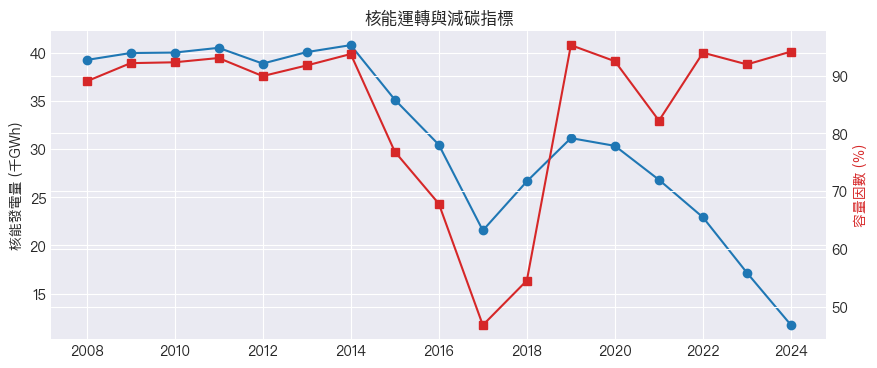

In [24]:

nuke = pd.read_csv(DATA_DIR / 'nuclear_generation_performance.csv').sort_values('year')
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(nuke['year'], nuke['generation_gwh'] / 1000, label='核能發電量 (千GWh)', marker='o')
ax.set_ylabel('核能發電量 (千GWh)')
ax2 = ax.twinx()
ax2.plot(nuke['year'], nuke['capacity_factor_pct'], color='tab:red', label='容量因數 (%)', marker='s')
ax2.set_ylabel('容量因數 (%)', color='tab:red')
ax.set_title('核能運轉與減碳指標')
plt.show()

context['nuke'] = {
    'year': int(nuke['year'].iloc[-1]),
    'generation': float(nuke['generation_gwh'].iloc[-1] / 1000),
    'capacity_factor': float(nuke['capacity_factor_pct'].iloc[-1]),
    'reduction': float(nuke['co2_reduction_tonnes'].iloc[-1] / 1e6)
}


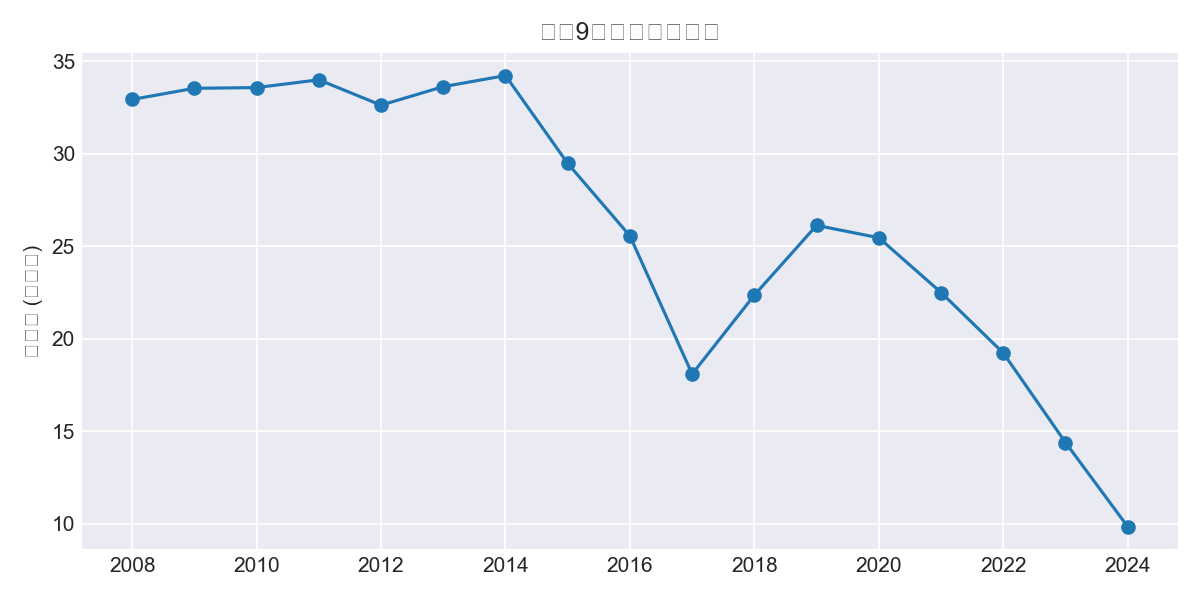

In [ ]:

data = context['nuke']
text = f"""
**圖表解讀**<br>
1. 核能発電量自 2020 年 30.3 千GWh 降至 {data['generation']:.1f} 千GWh ({data['year']} 年)。<br>
2. 容量因數仍維持 {data['capacity_factor']:.1f}% 。<br>
3. 減碳量降至 {data['reduction']:.2f} 百萬噸。<br>
4. 核能退場後需以燃氣補足，推升碳排與成本。<br>
5. 若延宕儲能與再生建置，供電風險上升。<br>
6. 可評估 SMR 或延役以兼顧減碳與穩定。<br>
"""
Markdown(text)



## 11. 結論與政策建議
- **供電穩定**：尖峰負載創新高、備轉率降至 11% 左右，夏季多次跌破 6%，需強化調度容量與需求反應。
- **燃煤/燃氣依賴**：燃氣占比近 50%，燃煤仍逾 30%，再生能源尚不足以完全替代，應同步推動風光儲與多元氣源。
- **再生能源**：太陽光電與風電裝置增長快速，但夜間與冬季仍缺乏可調度電源，需搭配儲能與虛擬電廠。
- **核能影響**：核能發電與減碳量大幅下滑，若維持非核家園，需以更積極的再生能源與儲能計畫填補缺口。
- **成本與電價**：核能成本最低，再生能源與購入電力較高，顯示電價壓力存在；需建立透明的成本轉嫁與碳費機制。
- **未來方向**：推動「供給多元化 + 需求反應 + 儲能 + 氣源備援」的矩陣策略，並訂定法定備轉門檻與預警機制，確保能源轉型與供電安全並行。
